# Inferential statistics II - Bootstrapping

## Introduction

In the previous exercises you performed frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold in your case, and what you want to do has a known theoretical distribution, for example the mean of a sampling distribution that we looked at.

In these exercises we are once again going to load in the medical charge data but this time we are going to make inferences about the population using bootstrapping, that is simulating repeated re-runs of an experiment. If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

Whilst these exercises do not strictly depend on these concepts, before working through them, you should have completed the preceding assignment and have a good understanding of such frequentist concepts as
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete these exercises, you should have covered the material on how to calculate bootstrap replicates of summary statistics. Having an appreciation of what confidence intervals and p-values are will be helpful.

In [62]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [63]:
med_charges = pd.read_csv('../data/insurance2.csv')

In [64]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you would like to verify your calculations and check you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [65]:
# Bootstrap Sampling
def bootstrap_replicates(x,func,size=10000):
    ''' Calculate the bootstrap replicates for a 1D array '''
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(x,size=len(x))
        bs_replicates[i] = func(bs_sample)
    return bs_replicates

In [66]:
np.random.seed(47)
np.percentile(bootstrap_replicates(med_charges['charges'],np.mean),[5.0])

array([12724.4679217])

If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember in the previous exercise set, we saw there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__

In [67]:
print ('Test-statistic: Difference of standard deviations ( between insured and non-insured)')
print ('Null Hypothesis: Both have identical standard deviations  ( sd_0 - sd_1 = 0)')
print ('Alternate Hypothesis: Differ in their standard deviations  ( sd_0 - sd_1 != 0)')

Test-statistic: Difference of standard deviations ( between insured and non-insured)
Null Hypothesis: Both have identical standard deviations  ( sd_0 - sd_1 = 0)
Alternate Hypothesis: Differ in their standard deviations  ( sd_0 - sd_1 != 0)


In [68]:
def difference(x,y,func):
    ''' Calculate the difference of statistic for two 1D arrays '''
    return bootstrap_replicates(x,func=func) - bootstrap_replicates(y,func=func)

In [69]:
diff_std=difference(med_charges.charges[med_charges['insuranceclaim'] == 1],med_charges.charges[med_charges['insuranceclaim'] == 0],np.std)
empirical_std =np.std(med_charges.charges[med_charges['insuranceclaim'] == 1]) - np.std(med_charges.charges[med_charges['insuranceclaim'] == 0])
ci_low ,ci_high = (np.percentile(diff_std,[2.5]),np.percentile(diff_std,[97.5]))
print('ci_low:',str(ci_low),'ci_high:',str(ci_high),'\nEmpirical std dev. difference',str(empirical_std))

ci_low: [6670.01798997] ci_high: [8504.74868331] 
Empirical std dev. difference 7596.256408655178


95% Confidence Interval: [6670.01798997] [8504.74868331]


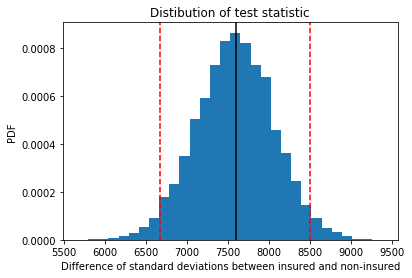

In [70]:
# plot the distribution of difference in standard deviations from bootstrap sampling
_ = plt.hist(diff_std,bins=30,density=True)

#plot the confidence interval and observed statistic
_ = plt.axvline(empirical_std, color='k')
_ = plt.axvline(ci_low,linestyle='--', color='r')
_ = plt.axvline(ci_high,linestyle='--', color='r')

# label the axes
_ = plt.xlabel('Difference of standard deviations between insured and non-insured')
_ = plt.ylabel('PDF')
_ = plt.title('Distibution of test statistic')
print("95% Confidence Interval:",ci_low ,ci_high)

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type II error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this but using the bootstrap.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__

In [71]:
# Performing t-test on two independant sample for difference in means
print ('Test-statistic: Difference of means ( between insured and non-insured)')
print ('Null Hypothesis: Both have identical means  ( mean_0 - mean_1 = 0)')
print ('Alternate Hypothesis: Differ in their means  ( mean_0 - mean_1 != 0)')
print ('Assumed Significance level: (𝛼 =0.05) ')

Test-statistic: Difference of means ( between insured and non-insured)
Null Hypothesis: Both have identical means  ( mean_0 - mean_1 = 0)
Alternate Hypothesis: Differ in their means  ( mean_0 - mean_1 != 0)
Assumed Significance level: (𝛼 =0.05) 


In [72]:
# Perform bootstrap hypothesis test

# Assuming null hypothesis is true - So shift both the arrays to have the same mean 
# since we are simulating the hypothesis that their mean are in fact, equal

# Compute mean of all charges
mean_charges = np.mean(med_charges.charges)

# Identify the Samples
charges_0 =(med_charges.charges[med_charges['insuranceclaim'] == 0])
charges_1 =(med_charges.charges[med_charges['insuranceclaim'] == 1])
            
# Shift both arrays to have the same observed mean
charges_0_shifted = charges_0 - np.mean(charges_0) + mean_charges
charges_1_shifted = charges_1 - np.mean(charges_1) + mean_charges

# Computed 10,000 bootstap replicates from shifted arrays
bs_replicates_0=bootstrap_replicates(charges_0_shifted,np.mean,size=10000)
bs_replicates_1=bootstrap_replicates(charges_1_shifted,np.mean,size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_1 - bs_replicates_0

#Calculate the empirical difference of means
empirical_diff_means = np.mean(charges_1) - np.mean(charges_0)

# Compute and p-value
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__

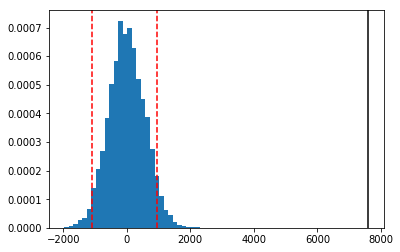

In [73]:
_ = plt.hist(bs_replicates,bins=30,density=True)
_ = plt.axvline(empirical_diff_means, color='k')
_ = plt.axvline(np.percentile(bs_replicates,[2.5]),linestyle='--', color='r')
_ = plt.axvline(np.percentile(bs_replicates,[95.5]),linestyle='--', color='r')

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ With test performed with 10,000 bootstrap replicates, we did not identify statistic as extreme as the empirical difference of means. This suggests, to perform the test with more number of bootstrap replicates.

__Q:__ Remember the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ we should consider using the t-test assuming the variances are not equal, which correctly suggests the p-value obtained through bootstrap sampling as well.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real world consequence of rejecting the null hypothesis?

__A:__
Yes, since we are dealing with two independant samples, we would still consider doing a two-sided test.
Null Hypothesis : Have identical mean click through rate for current and new algorithm
Alternative Hypothesis: Differ in their mean click through rate for current and new algorithm
Real-world consequence of rejecting the null hypothesis: Would be to make inferences - new algorithm performing better than current or new algorithm under performing than current based on the  statistic(mean click through rates).

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.